In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 50
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def nlp_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    output = Dense(units=1, activation='sigmoid')(lstm1[1])

    model = Model(inputs, output)
    return model


model = nlp_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm1.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14114800  
_________________________________________________________________
lstm (LSTM)                  [(None, 200, 50), (None,  30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 14,145,051
Trainable params: 30,251
Non-trainable params: 14,114,800
_________________________________________________________________
Epoch 1/500
133/133 [==============================] - ETA: 0s - loss: 8.7276 - accuracy: 0.5165
Epoch 00001: val_accuracy improved from -inf to 0.55430, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==========================

Epoch 24/500
131/133 [============================>.] - ETA: 0s - loss: 0.5697 - accuracy: 0.7889
Epoch 00024: val_accuracy improved from 0.80453 to 0.80925, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.5702 - accuracy: 0.7880 - val_loss: 0.5468 - val_accuracy: 0.8093
Epoch 25/500
131/133 [============================>.] - ETA: 0s - loss: 0.5678 - accuracy: 0.7863
Epoch 00025: val_accuracy improved from 0.80925 to 0.81114, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.5674 - accuracy: 0.7866 - val_loss: 0.5467 - val_accuracy: 0.8111
Epoch 26/500
131/133 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7913
Epoch 00026: val_accuracy did not improve from 0.81114
133/133 [==============================] - 2s 13ms/step - loss: 0.5673 - accuracy: 0.7916 - val_loss: 0.5527 - val_accuracy: 0.7932
Epoch 27/500
131/133 [=====================

131/133 [============================>.] - ETA: 0s - loss: 0.4939 - accuracy: 0.8235
Epoch 00051: val_accuracy did not improve from 0.83569
133/133 [==============================] - 2s 13ms/step - loss: 0.4937 - accuracy: 0.8237 - val_loss: 0.4864 - val_accuracy: 0.8347
Epoch 52/500
131/133 [============================>.] - ETA: 0s - loss: 0.4972 - accuracy: 0.8309
Epoch 00052: val_accuracy did not improve from 0.83569
133/133 [==============================] - 2s 13ms/step - loss: 0.4966 - accuracy: 0.8310 - val_loss: 0.4866 - val_accuracy: 0.8310
Epoch 53/500
131/133 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.8213
Epoch 00053: val_accuracy improved from 0.83569 to 0.84136, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.4951 - accuracy: 0.8211 - val_loss: 0.4880 - val_accuracy: 0.8414
Epoch 54/500
131/133 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.8333
Epoch 000

Epoch 79/500
131/133 [============================>.] - ETA: 0s - loss: 0.4480 - accuracy: 0.8552
Epoch 00079: val_accuracy did not improve from 0.85080
133/133 [==============================] - 2s 13ms/step - loss: 0.4482 - accuracy: 0.8549 - val_loss: 0.4747 - val_accuracy: 0.8300
Epoch 80/500
131/133 [============================>.] - ETA: 0s - loss: 0.4489 - accuracy: 0.8597
Epoch 00080: val_accuracy did not improve from 0.85080
133/133 [==============================] - 2s 13ms/step - loss: 0.4497 - accuracy: 0.8594 - val_loss: 0.4607 - val_accuracy: 0.8442
Epoch 81/500
131/133 [============================>.] - ETA: 0s - loss: 0.4450 - accuracy: 0.8585
Epoch 00081: val_accuracy improved from 0.85080 to 0.85364, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.4446 - accuracy: 0.8589 - val_loss: 0.4543 - val_accuracy: 0.8536
Epoch 82/500
131/133 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.8

Epoch 107/500
131/133 [============================>.] - ETA: 0s - loss: 0.4191 - accuracy: 0.8702
Epoch 00107: val_accuracy improved from 0.86213 to 0.86308, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.4185 - accuracy: 0.8707 - val_loss: 0.4299 - val_accuracy: 0.8631
Epoch 108/500
131/133 [============================>.] - ETA: 0s - loss: 0.4140 - accuracy: 0.8757
Epoch 00108: val_accuracy did not improve from 0.86308
133/133 [==============================] - 2s 13ms/step - loss: 0.4146 - accuracy: 0.8755 - val_loss: 0.4609 - val_accuracy: 0.8499
Epoch 109/500
131/133 [============================>.] - ETA: 0s - loss: 0.4175 - accuracy: 0.8724
Epoch 00109: val_accuracy improved from 0.86308 to 0.86591, saving model to ./weight_cp\weight_lstm1.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.4177 - accuracy: 0.8722 - val_loss: 0.4365 - val_accuracy: 0.8659
Epoch 110/500
131/133 [=================

Epoch 135/500
131/133 [============================>.] - ETA: 0s - loss: 0.3883 - accuracy: 0.8898
Epoch 00135: val_accuracy did not improve from 0.86874
133/133 [==============================] - 2s 13ms/step - loss: 0.3900 - accuracy: 0.8892 - val_loss: 0.4262 - val_accuracy: 0.8621
Epoch 136/500
131/133 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.8810
Epoch 00136: val_accuracy did not improve from 0.86874
133/133 [==============================] - 2s 13ms/step - loss: 0.3943 - accuracy: 0.8811 - val_loss: 0.4207 - val_accuracy: 0.8574
Epoch 137/500
131/133 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8817
Epoch 00137: val_accuracy did not improve from 0.86874
133/133 [==============================] - 2s 13ms/step - loss: 0.3907 - accuracy: 0.8826 - val_loss: 0.4184 - val_accuracy: 0.8669
Epoch 138/500
131/133 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8903
Epoch 00138: val_accuracy improved from 0.8

Epoch 163/500
131/133 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.8931
Epoch 00163: val_accuracy did not improve from 0.87630
133/133 [==============================] - 2s 13ms/step - loss: 0.3757 - accuracy: 0.8939 - val_loss: 0.4188 - val_accuracy: 0.8754
Epoch 164/500
131/133 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8938
Epoch 00164: val_accuracy did not improve from 0.87630
133/133 [==============================] - 2s 13ms/step - loss: 0.3718 - accuracy: 0.8948 - val_loss: 0.4148 - val_accuracy: 0.8678
Epoch 165/500
131/133 [============================>.] - ETA: 0s - loss: 0.3714 - accuracy: 0.8979
Epoch 00165: val_accuracy did not improve from 0.87630
133/133 [==============================] - 2s 13ms/step - loss: 0.3703 - accuracy: 0.8984 - val_loss: 0.4020 - val_accuracy: 0.8687
Epoch 166/500
131/133 [============================>.] - ETA: 0s - loss: 0.3627 - accuracy: 0.9012
Epoch 00166: val_accuracy did not improve f

131/133 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.9010
Epoch 00191: val_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 13ms/step - loss: 0.3607 - accuracy: 0.9003 - val_loss: 0.4066 - val_accuracy: 0.8791
Epoch 192/500
131/133 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8991
Epoch 00192: val_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 13ms/step - loss: 0.3607 - accuracy: 0.8998 - val_loss: 0.4106 - val_accuracy: 0.8857
Epoch 193/500
131/133 [============================>.] - ETA: 0s - loss: 0.3605 - accuracy: 0.9034
Epoch 00193: val_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 13ms/step - loss: 0.3609 - accuracy: 0.9036 - val_loss: 0.4078 - val_accuracy: 0.8801
Epoch 194/500
131/133 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.9067
Epoch 00194: val_accuracy did not improve from 0.88574
13

Epoch 220/500
131/133 [============================>.] - ETA: 0s - loss: 0.3441 - accuracy: 0.9077
Epoch 00220: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3443 - accuracy: 0.9074 - val_loss: 0.4096 - val_accuracy: 0.8829
Epoch 221/500
131/133 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.9067
Epoch 00221: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3454 - accuracy: 0.9074 - val_loss: 0.3977 - val_accuracy: 0.8829
Epoch 222/500
131/133 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.9065
Epoch 00222: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3436 - accuracy: 0.9064 - val_loss: 0.3978 - val_accuracy: 0.8810
Epoch 223/500
131/133 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.9098
Epoch 00223: val_accuracy did not improve f

Epoch 249/500
131/133 [============================>.] - ETA: 0s - loss: 0.3403 - accuracy: 0.9084
Epoch 00249: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3399 - accuracy: 0.9088 - val_loss: 0.3858 - val_accuracy: 0.8810
Epoch 250/500
131/133 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.9163
Epoch 00250: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3280 - accuracy: 0.9147 - val_loss: 0.3927 - val_accuracy: 0.8876
Epoch 251/500
131/133 [============================>.] - ETA: 0s - loss: 0.3311 - accuracy: 0.9158
Epoch 00251: val_accuracy did not improve from 0.89046
133/133 [==============================] - 2s 13ms/step - loss: 0.3315 - accuracy: 0.9152 - val_loss: 0.3885 - val_accuracy: 0.8895
Epoch 252/500
131/133 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.9165
Epoch 00252: val_accuracy did not improve f

Epoch 278/500
129/133 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.9145
Epoch 00278: val_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 13ms/step - loss: 0.3285 - accuracy: 0.9140 - val_loss: 0.3805 - val_accuracy: 0.8914
Epoch 279/500
131/133 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.9206
Epoch 00279: val_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 13ms/step - loss: 0.3200 - accuracy: 0.9208 - val_loss: 0.3894 - val_accuracy: 0.8857
Epoch 280/500
131/133 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.9117
Epoch 00280: val_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 13ms/step - loss: 0.3290 - accuracy: 0.9116 - val_loss: 0.4179 - val_accuracy: 0.8744
Epoch 281/500
131/133 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.9132
Epoch 00281: val_accuracy did not improve f

Epoch 307/500
131/133 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.9191
Epoch 00307: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 13ms/step - loss: 0.3143 - accuracy: 0.9192 - val_loss: 0.3969 - val_accuracy: 0.8895
Epoch 308/500
131/133 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.9208
Epoch 00308: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 13ms/step - loss: 0.3139 - accuracy: 0.9206 - val_loss: 0.3950 - val_accuracy: 0.8725
Epoch 309/500
131/133 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.9103
Epoch 00309: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 13ms/step - loss: 0.3241 - accuracy: 0.9102 - val_loss: 0.3821 - val_accuracy: 0.8839
Epoch 310/500
131/133 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.9232
Epoch 00310: val_accuracy did not improve f

Epoch 336/500
132/133 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.9240
Epoch 00336: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3087 - accuracy: 0.9237 - val_loss: 0.3774 - val_accuracy: 0.8820
Epoch 337/500
132/133 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.9221
Epoch 00337: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3086 - accuracy: 0.9223 - val_loss: 0.3850 - val_accuracy: 0.8905
Epoch 338/500
132/133 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.9240
Epoch 00338: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3056 - accuracy: 0.9239 - val_loss: 0.3782 - val_accuracy: 0.8914
Epoch 339/500
132/133 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.9195
Epoch 00339: val_accuracy did not improve f

Epoch 365/500
131/133 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.9268
Epoch 00365: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3034 - accuracy: 0.9267 - val_loss: 0.4234 - val_accuracy: 0.8791
Epoch 366/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.9272
Epoch 00366: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2956 - accuracy: 0.9267 - val_loss: 0.3806 - val_accuracy: 0.8839
Epoch 367/500
132/133 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.9193
Epoch 00367: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3129 - accuracy: 0.9194 - val_loss: 0.4610 - val_accuracy: 0.8621
Epoch 368/500
131/133 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.9277
Epoch 00368: val_accuracy did not improve f

Epoch 394/500
131/133 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.9299
Epoch 00394: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2938 - accuracy: 0.9301 - val_loss: 0.3819 - val_accuracy: 0.8905
Epoch 395/500
131/133 [============================>.] - ETA: 0s - loss: 0.3063 - accuracy: 0.9249
Epoch 00395: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.3059 - accuracy: 0.9251 - val_loss: 0.3944 - val_accuracy: 0.8687
Epoch 396/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2977 - accuracy: 0.9272
Epoch 00396: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2997 - accuracy: 0.9263 - val_loss: 0.4312 - val_accuracy: 0.8754
Epoch 397/500
132/133 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.9195
Epoch 00397: val_accuracy did not improve f

Epoch 423/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2924 - accuracy: 0.9272
Epoch 00423: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2932 - accuracy: 0.9272 - val_loss: 0.4118 - val_accuracy: 0.8782
Epoch 424/500
131/133 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.9299
Epoch 00424: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2894 - accuracy: 0.9296 - val_loss: 0.3912 - val_accuracy: 0.8669
Epoch 425/500
132/133 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.9257
Epoch 00425: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2937 - accuracy: 0.9256 - val_loss: 0.3846 - val_accuracy: 0.8754
Epoch 426/500
132/133 [============================>.] - ETA: 0s - loss: 0.2953 - accuracy: 0.9233
Epoch 00426: val_accuracy did not improve f

Epoch 452/500
129/133 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.9285
Epoch 00452: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2886 - accuracy: 0.9286 - val_loss: 0.4466 - val_accuracy: 0.8669
Epoch 453/500
131/133 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.9234
Epoch 00453: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2937 - accuracy: 0.9234 - val_loss: 0.3682 - val_accuracy: 0.8980
Epoch 454/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2864 - accuracy: 0.9312
Epoch 00454: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2864 - accuracy: 0.9315 - val_loss: 0.3823 - val_accuracy: 0.8952
Epoch 455/500
132/133 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.9318
Epoch 00455: val_accuracy did not improve f

Epoch 481/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2841 - accuracy: 0.9314
Epoch 00481: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2846 - accuracy: 0.9305 - val_loss: 0.3739 - val_accuracy: 0.8857
Epoch 482/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.9348
Epoch 00482: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2792 - accuracy: 0.9355 - val_loss: 0.3914 - val_accuracy: 0.8857
Epoch 483/500
131/133 [============================>.] - ETA: 0s - loss: 0.2769 - accuracy: 0.9351
Epoch 00483: val_accuracy did not improve from 0.90085
133/133 [==============================] - 2s 12ms/step - loss: 0.2772 - accuracy: 0.9348 - val_loss: 0.4125 - val_accuracy: 0.8791
Epoch 484/500
128/133 [===========================>..] - ETA: 0s - loss: 0.2799 - accuracy: 0.9321
Epoch 00484: val_accuracy did not improve f

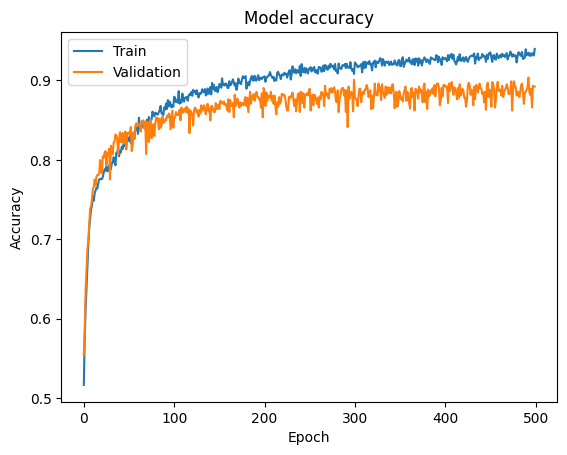

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model = load_model('./weight_cp/weight_lstm1.hdf5')
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF LSTM
              precision    recall  f1-score   support

           0       0.84      0.94      0.88       661
           1       0.93      0.82      0.87       662

    accuracy                           0.88      1323
   macro avg       0.88      0.88      0.88      1323
weighted avg       0.88      0.88      0.88      1323

0.8783068783068783


In [10]:
def nlp_lstm2(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = nlp_lstm2(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])








(None, 80)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 50), (N 30200       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       51          lstm_1[0][0]                     
____________________________________________________________________________

130/133 [============================>.] - ETA: 0s - loss: 4.3334 - op_main_loss: 0.5722 - op_conv_loss: 0.6926 - avg_loss: 0.6236 - op_main_accuracy: 0.7228 - op_conv_accuracy: 0.5197 - avg_accuracy: 0.7214
Epoch 00006: val_avg_accuracy improved from 0.71010 to 0.73182, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 4.3280 - op_main_loss: 0.5719 - op_conv_loss: 0.6926 - avg_loss: 0.6233 - op_main_accuracy: 0.7226 - op_conv_accuracy: 0.5194 - avg_accuracy: 0.7212 - val_loss: 4.0149 - val_op_main_loss: 0.5570 - val_op_conv_loss: 0.6918 - val_avg_loss: 0.6138 - val_op_main_accuracy: 0.7337 - val_op_conv_accuracy: 0.5024 - val_avg_accuracy: 0.7318
Epoch 7/500
129/133 [============================>.] - ETA: 0s - loss: 3.7709 - op_main_loss: 0.5493 - op_conv_loss: 0.6909 - avg_loss: 0.6089 - op_main_accuracy: 0.7362 - op_conv_accuracy: 0.5451 - avg_accuracy: 0.7340
Epoch 00007: val_avg_accuracy improved from 0.73182 to 0.74315, 

133/133 [==============================] - 2s 16ms/step - loss: 1.6937 - op_main_loss: 0.4095 - op_conv_loss: 0.4076 - avg_loss: 0.3999 - op_main_accuracy: 0.8237 - op_conv_accuracy: 0.8228 - avg_accuracy: 0.8306 - val_loss: 1.6656 - val_op_main_loss: 0.3999 - val_op_conv_loss: 0.4049 - val_avg_loss: 0.3934 - val_op_main_accuracy: 0.8206 - val_op_conv_accuracy: 0.8178 - val_avg_accuracy: 0.8291
Epoch 18/500
129/133 [============================>.] - ETA: 0s - loss: 1.6595 - op_main_loss: 0.4071 - op_conv_loss: 0.3978 - avg_loss: 0.3945 - op_main_accuracy: 0.8304 - op_conv_accuracy: 0.8207 - avg_accuracy: 0.8309
Epoch 00018: val_avg_accuracy improved from 0.82908 to 0.83003, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 1.6586 - op_main_loss: 0.4074 - op_conv_loss: 0.3972 - avg_loss: 0.3943 - op_main_accuracy: 0.8308 - op_conv_accuracy: 0.8209 - avg_accuracy: 0.8315 - val_loss: 1.6315 - val_op_main_loss: 0.3950 - val_op_con

Epoch 29/500
130/133 [============================>.] - ETA: 0s - loss: 1.3467 - op_main_loss: 0.3488 - op_conv_loss: 0.2916 - avg_loss: 0.3118 - op_main_accuracy: 0.8635 - op_conv_accuracy: 0.8776 - avg_accuracy: 0.8776
Epoch 00029: val_avg_accuracy did not improve from 0.85458
133/133 [==============================] - 2s 14ms/step - loss: 1.3505 - op_main_loss: 0.3497 - op_conv_loss: 0.2934 - avg_loss: 0.3129 - op_main_accuracy: 0.8632 - op_conv_accuracy: 0.8774 - avg_accuracy: 0.8776 - val_loss: 1.4999 - val_op_main_loss: 0.3678 - val_op_conv_loss: 0.3805 - val_avg_loss: 0.3586 - val_op_main_accuracy: 0.8404 - val_op_conv_accuracy: 0.8319 - val_avg_accuracy: 0.8366
Epoch 30/500
132/133 [============================>.] - ETA: 0s - loss: 1.3311 - op_main_loss: 0.3441 - op_conv_loss: 0.2882 - avg_loss: 0.3074 - op_main_accuracy: 0.8665 - op_conv_accuracy: 0.8830 - avg_accuracy: 0.8840
Epoch 00030: val_avg_accuracy did not improve from 0.85458
133/133 [==============================] -

Epoch 41/500
132/133 [============================>.] - ETA: 0s - loss: 1.1728 - op_main_loss: 0.3053 - op_conv_loss: 0.2316 - avg_loss: 0.2582 - op_main_accuracy: 0.8814 - op_conv_accuracy: 0.9117 - avg_accuracy: 0.9086
Epoch 00041: val_avg_accuracy did not improve from 0.87252
133/133 [==============================] - 2s 14ms/step - loss: 1.1736 - op_main_loss: 0.3058 - op_conv_loss: 0.2317 - avg_loss: 0.2585 - op_main_accuracy: 0.8809 - op_conv_accuracy: 0.9116 - avg_accuracy: 0.9083 - val_loss: 1.3828 - val_op_main_loss: 0.3463 - val_op_conv_loss: 0.3353 - val_avg_loss: 0.3244 - val_op_main_accuracy: 0.8480 - val_op_conv_accuracy: 0.8621 - val_avg_accuracy: 0.8574
Epoch 42/500
130/133 [============================>.] - ETA: 0s - loss: 1.1735 - op_main_loss: 0.3063 - op_conv_loss: 0.2321 - avg_loss: 0.2591 - op_main_accuracy: 0.8776 - op_conv_accuracy: 0.9070 - avg_accuracy: 0.9046
Epoch 00042: val_avg_accuracy did not improve from 0.87252
133/133 [==============================] -

Epoch 53/500
130/133 [============================>.] - ETA: 0s - loss: 1.0726 - op_main_loss: 0.2799 - op_conv_loss: 0.1973 - avg_loss: 0.2284 - op_main_accuracy: 0.8923 - op_conv_accuracy: 0.9269 - avg_accuracy: 0.9185
Epoch 00053: val_avg_accuracy improved from 0.88102 to 0.88385, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 1.0763 - op_main_loss: 0.2811 - op_conv_loss: 0.1986 - avg_loss: 0.2296 - op_main_accuracy: 0.8918 - op_conv_accuracy: 0.9258 - avg_accuracy: 0.9178 - val_loss: 1.2630 - val_op_main_loss: 0.3033 - val_op_conv_loss: 0.3070 - val_avg_loss: 0.2865 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8763 - val_avg_accuracy: 0.8839
Epoch 54/500
129/133 [============================>.] - ETA: 0s - loss: 1.0756 - op_main_loss: 0.2785 - op_conv_loss: 0.2012 - avg_loss: 0.2295 - op_main_accuracy: 0.8886 - op_conv_accuracy: 0.9193 - avg_accuracy: 0.9167
Epoch 00054: val_avg_accuracy did not improve from

129/133 [============================>.] - ETA: 0s - loss: 1.0010 - op_main_loss: 0.2584 - op_conv_loss: 0.1763 - avg_loss: 0.2077 - op_main_accuracy: 0.9053 - op_conv_accuracy: 0.9295 - avg_accuracy: 0.9288
Epoch 00065: val_avg_accuracy did not improve from 0.88385
133/133 [==============================] - 2s 14ms/step - loss: 1.0042 - op_main_loss: 0.2591 - op_conv_loss: 0.1776 - avg_loss: 0.2088 - op_main_accuracy: 0.9048 - op_conv_accuracy: 0.9289 - avg_accuracy: 0.9279 - val_loss: 1.1745 - val_op_main_loss: 0.2829 - val_op_conv_loss: 0.2724 - val_avg_loss: 0.2614 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8867 - val_avg_accuracy: 0.8791
Epoch 66/500
130/133 [============================>.] - ETA: 0s - loss: 1.0135 - op_main_loss: 0.2632 - op_conv_loss: 0.1804 - avg_loss: 0.2122 - op_main_accuracy: 0.9019 - op_conv_accuracy: 0.9291 - avg_accuracy: 0.9284
Epoch 00066: val_avg_accuracy did not improve from 0.88385
133/133 [==============================] - 2s 14ms/step

Epoch 77/500
133/133 [==============================] - ETA: 0s - loss: 0.9572 - op_main_loss: 0.2450 - op_conv_loss: 0.1652 - avg_loss: 0.1961 - op_main_accuracy: 0.9126 - op_conv_accuracy: 0.9345 - avg_accuracy: 0.9343
Epoch 00077: val_avg_accuracy did not improve from 0.89141
133/133 [==============================] - 2s 14ms/step - loss: 0.9572 - op_main_loss: 0.2450 - op_conv_loss: 0.1652 - avg_loss: 0.1961 - op_main_accuracy: 0.9126 - op_conv_accuracy: 0.9345 - avg_accuracy: 0.9343 - val_loss: 1.1529 - val_op_main_loss: 0.2781 - val_op_conv_loss: 0.2686 - val_avg_loss: 0.2559 - val_op_main_accuracy: 0.8810 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8867
Epoch 78/500
133/133 [==============================] - ETA: 0s - loss: 0.9496 - op_main_loss: 0.2431 - op_conv_loss: 0.1629 - avg_loss: 0.1935 - op_main_accuracy: 0.9090 - op_conv_accuracy: 0.9364 - avg_accuracy: 0.9362
Epoch 00078: val_avg_accuracy improved from 0.89141 to 0.89330, saving model to ./weight_cp\weight_ls

133/133 [==============================] - ETA: 0s - loss: 0.9226 - op_main_loss: 0.2353 - op_conv_loss: 0.1563 - avg_loss: 0.1861 - op_main_accuracy: 0.9112 - op_conv_accuracy: 0.9407 - avg_accuracy: 0.9345
Epoch 00089: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 14ms/step - loss: 0.9226 - op_main_loss: 0.2353 - op_conv_loss: 0.1563 - avg_loss: 0.1861 - op_main_accuracy: 0.9112 - op_conv_accuracy: 0.9407 - avg_accuracy: 0.9345 - val_loss: 1.1314 - val_op_main_loss: 0.2677 - val_op_conv_loss: 0.2697 - val_avg_loss: 0.2493 - val_op_main_accuracy: 0.8801 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8876
Epoch 90/500
130/133 [============================>.] - ETA: 0s - loss: 0.9112 - op_main_loss: 0.2368 - op_conv_loss: 0.1474 - avg_loss: 0.1823 - op_main_accuracy: 0.9099 - op_conv_accuracy: 0.9416 - avg_accuracy: 0.9392
Epoch 00090: val_avg_accuracy did not improve from 0.89330
133/133 [==============================] - 2s 14ms/step

Epoch 101/500
131/133 [============================>.] - ETA: 0s - loss: 0.8723 - op_main_loss: 0.2183 - op_conv_loss: 0.1432 - avg_loss: 0.1706 - op_main_accuracy: 0.9246 - op_conv_accuracy: 0.9447 - avg_accuracy: 0.9449
Epoch 00101: val_avg_accuracy did not improve from 0.89707
133/133 [==============================] - 2s 14ms/step - loss: 0.8733 - op_main_loss: 0.2187 - op_conv_loss: 0.1434 - avg_loss: 0.1709 - op_main_accuracy: 0.9244 - op_conv_accuracy: 0.9447 - avg_accuracy: 0.9449 - val_loss: 1.1536 - val_op_main_loss: 0.2741 - val_op_conv_loss: 0.2847 - val_avg_loss: 0.2552 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.9008 - val_avg_accuracy: 0.8961
Epoch 102/500
132/133 [============================>.] - ETA: 0s - loss: 0.8847 - op_main_loss: 0.2272 - op_conv_loss: 0.1430 - avg_loss: 0.1756 - op_main_accuracy: 0.9200 - op_conv_accuracy: 0.9446 - avg_accuracy: 0.9411
Epoch 00102: val_avg_accuracy improved from 0.89707 to 0.89896, saving model to ./weight_cp\weight_

Epoch 113/500
130/133 [============================>.] - ETA: 0s - loss: 0.8447 - op_main_loss: 0.2155 - op_conv_loss: 0.1297 - avg_loss: 0.1635 - op_main_accuracy: 0.9154 - op_conv_accuracy: 0.9481 - avg_accuracy: 0.9447
Epoch 00113: val_avg_accuracy improved from 0.90085 to 0.90274, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 0.8432 - op_main_loss: 0.2147 - op_conv_loss: 0.1295 - avg_loss: 0.1630 - op_main_accuracy: 0.9159 - op_conv_accuracy: 0.9483 - avg_accuracy: 0.9449 - val_loss: 1.1442 - val_op_main_loss: 0.2695 - val_op_conv_loss: 0.2864 - val_avg_loss: 0.2525 - val_op_main_accuracy: 0.8810 - val_op_conv_accuracy: 0.8999 - val_avg_accuracy: 0.9027
Epoch 114/500
133/133 [==============================] - ETA: 0s - loss: 0.8577 - op_main_loss: 0.2157 - op_conv_loss: 0.1399 - avg_loss: 0.1673 - op_main_accuracy: 0.9216 - op_conv_accuracy: 0.9473 - avg_accuracy: 0.9464
Epoch 00114: val_avg_accuracy did not improve fr

Epoch 125/500
129/133 [============================>.] - ETA: 0s - loss: 0.8182 - op_main_loss: 0.2053 - op_conv_loss: 0.1254 - avg_loss: 0.1566 - op_main_accuracy: 0.9278 - op_conv_accuracy: 0.9501 - avg_accuracy: 0.9450
Epoch 00125: val_avg_accuracy did not improve from 0.90274
133/133 [==============================] - 2s 14ms/step - loss: 0.8185 - op_main_loss: 0.2055 - op_conv_loss: 0.1254 - avg_loss: 0.1567 - op_main_accuracy: 0.9282 - op_conv_accuracy: 0.9501 - avg_accuracy: 0.9452 - val_loss: 1.1961 - val_op_main_loss: 0.2721 - val_op_conv_loss: 0.3259 - val_avg_loss: 0.2671 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8914
Epoch 126/500
133/133 [==============================] - ETA: 0s - loss: 0.8138 - op_main_loss: 0.2057 - op_conv_loss: 0.1222 - avg_loss: 0.1553 - op_main_accuracy: 0.9289 - op_conv_accuracy: 0.9530 - avg_accuracy: 0.9516
Epoch 00126: val_avg_accuracy did not improve from 0.90274
133/133 [==============================]

Epoch 137/500
133/133 [==============================] - ETA: 0s - loss: 0.7851 - op_main_loss: 0.1966 - op_conv_loss: 0.1159 - avg_loss: 0.1469 - op_main_accuracy: 0.9301 - op_conv_accuracy: 0.9582 - avg_accuracy: 0.9556
Epoch 00137: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/step - loss: 0.7851 - op_main_loss: 0.1966 - op_conv_loss: 0.1159 - avg_loss: 0.1469 - op_main_accuracy: 0.9301 - op_conv_accuracy: 0.9582 - avg_accuracy: 0.9556 - val_loss: 1.0743 - val_op_main_loss: 0.2500 - val_op_conv_loss: 0.2651 - val_avg_loss: 0.2345 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9037
Epoch 138/500
133/133 [==============================] - ETA: 0s - loss: 0.8013 - op_main_loss: 0.2015 - op_conv_loss: 0.1222 - avg_loss: 0.1521 - op_main_accuracy: 0.9284 - op_conv_accuracy: 0.9513 - avg_accuracy: 0.9527
Epoch 00138: val_avg_accuracy did not improve from 0.90840
133/133 [==============================]

129/133 [============================>.] - ETA: 0s - loss: 0.7528 - op_main_loss: 0.1861 - op_conv_loss: 0.1057 - avg_loss: 0.1385 - op_main_accuracy: 0.9397 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9598
Epoch 00149: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/step - loss: 0.7552 - op_main_loss: 0.1870 - op_conv_loss: 0.1063 - avg_loss: 0.1393 - op_main_accuracy: 0.9393 - op_conv_accuracy: 0.9594 - avg_accuracy: 0.9594 - val_loss: 1.3451 - val_op_main_loss: 0.2931 - val_op_conv_loss: 0.4231 - val_avg_loss: 0.3059 - val_op_main_accuracy: 0.8829 - val_op_conv_accuracy: 0.8725 - val_avg_accuracy: 0.8754
Epoch 150/500
129/133 [============================>.] - ETA: 0s - loss: 0.7781 - op_main_loss: 0.1910 - op_conv_loss: 0.1183 - avg_loss: 0.1462 - op_main_accuracy: 0.9346 - op_conv_accuracy: 0.9535 - avg_accuracy: 0.9523
Epoch 00150: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7414 - op_main_loss: 0.1825 - op_conv_loss: 0.1048 - avg_loss: 0.1352 - op_main_accuracy: 0.9334 - op_conv_accuracy: 0.9613 - avg_accuracy: 0.9563
Epoch 00161: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/step - loss: 0.7415 - op_main_loss: 0.1830 - op_conv_loss: 0.1044 - avg_loss: 0.1353 - op_main_accuracy: 0.9334 - op_conv_accuracy: 0.9612 - avg_accuracy: 0.9563 - val_loss: 1.0949 - val_op_main_loss: 0.2535 - val_op_conv_loss: 0.2812 - val_avg_loss: 0.2422 - val_op_main_accuracy: 0.8933 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9065
Epoch 162/500
133/133 [==============================] - ETA: 0s - loss: 0.7647 - op_main_loss: 0.1900 - op_conv_loss: 0.1141 - avg_loss: 0.1429 - op_main_accuracy: 0.9317 - op_conv_accuracy: 0.9553 - avg_accuracy: 0.9565
Epoch 00162: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.7223 - op_main_loss: 0.1749 - op_conv_loss: 0.1008 - avg_loss: 0.1305 - op_main_accuracy: 0.9442 - op_conv_accuracy: 0.9599 - avg_accuracy: 0.9596
Epoch 00173: val_avg_accuracy did not improve from 0.90840
133/133 [==============================] - 2s 14ms/step - loss: 0.7211 - op_main_loss: 0.1745 - op_conv_loss: 0.1004 - avg_loss: 0.1301 - op_main_accuracy: 0.9445 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9598 - val_loss: 1.0923 - val_op_main_loss: 0.2454 - val_op_conv_loss: 0.2922 - val_avg_loss: 0.2387 - val_op_main_accuracy: 0.8999 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9037
Epoch 174/500
131/133 [============================>.] - ETA: 0s - loss: 0.7384 - op_main_loss: 0.1818 - op_conv_loss: 0.1056 - avg_loss: 0.1358 - op_main_accuracy: 0.9389 - op_conv_accuracy: 0.9568 - avg_accuracy: 0.9573
Epoch 00174: val_avg_accuracy improved from 0.90840 to 0.91029, saving model to ./weight_cp\weight_lstm2.hdf5
133

129/133 [============================>.] - ETA: 0s - loss: 0.7219 - op_main_loss: 0.1753 - op_conv_loss: 0.1038 - avg_loss: 0.1314 - op_main_accuracy: 0.9431 - op_conv_accuracy: 0.9598 - avg_accuracy: 0.9588
Epoch 00185: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 2s 14ms/step - loss: 0.7215 - op_main_loss: 0.1758 - op_conv_loss: 0.1030 - avg_loss: 0.1313 - op_main_accuracy: 0.9423 - op_conv_accuracy: 0.9603 - avg_accuracy: 0.9594 - val_loss: 1.0883 - val_op_main_loss: 0.2454 - val_op_conv_loss: 0.2933 - val_avg_loss: 0.2389 - val_op_main_accuracy: 0.9056 - val_op_conv_accuracy: 0.9103 - val_avg_accuracy: 0.9046
Epoch 186/500
130/133 [============================>.] - ETA: 0s - loss: 0.7175 - op_main_loss: 0.1768 - op_conv_loss: 0.1004 - avg_loss: 0.1302 - op_main_accuracy: 0.9416 - op_conv_accuracy: 0.9632 - avg_accuracy: 0.9599
Epoch 00186: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.7012 - op_main_loss: 0.1691 - op_conv_loss: 0.0981 - avg_loss: 0.1257 - op_main_accuracy: 0.9456 - op_conv_accuracy: 0.9642 - avg_accuracy: 0.9625
Epoch 00197: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 2s 14ms/step - loss: 0.7037 - op_main_loss: 0.1699 - op_conv_loss: 0.0991 - avg_loss: 0.1264 - op_main_accuracy: 0.9447 - op_conv_accuracy: 0.9636 - avg_accuracy: 0.9620 - val_loss: 1.0684 - val_op_main_loss: 0.2388 - val_op_conv_loss: 0.2877 - val_avg_loss: 0.2334 - val_op_main_accuracy: 0.8990 - val_op_conv_accuracy: 0.9056 - val_avg_accuracy: 0.9027
Epoch 198/500
129/133 [============================>.] - ETA: 0s - loss: 0.6932 - op_main_loss: 0.1669 - op_conv_loss: 0.0949 - avg_loss: 0.1234 - op_main_accuracy: 0.9482 - op_conv_accuracy: 0.9644 - avg_accuracy: 0.9627
Epoch 00198: val_avg_accuracy did not improve from 0.91029
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7025 - op_main_loss: 0.1762 - op_conv_loss: 0.0952 - avg_loss: 0.1268 - op_main_accuracy: 0.9371 - op_conv_accuracy: 0.9643 - avg_accuracy: 0.9615
Epoch 00209: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.7025 - op_main_loss: 0.1762 - op_conv_loss: 0.0952 - avg_loss: 0.1268 - op_main_accuracy: 0.9371 - op_conv_accuracy: 0.9643 - avg_accuracy: 0.9615 - val_loss: 1.1086 - val_op_main_loss: 0.2473 - val_op_conv_loss: 0.3116 - val_avg_loss: 0.2458 - val_op_main_accuracy: 0.8980 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.9046
Epoch 210/500
132/133 [============================>.] - ETA: 0s - loss: 0.7046 - op_main_loss: 0.1687 - op_conv_loss: 0.1036 - avg_loss: 0.1278 - op_main_accuracy: 0.9458 - op_conv_accuracy: 0.9600 - avg_accuracy: 0.9595
Epoch 00210: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6723 - op_main_loss: 0.1622 - op_conv_loss: 0.0899 - avg_loss: 0.1181 - op_main_accuracy: 0.9474 - op_conv_accuracy: 0.9663 - avg_accuracy: 0.9635
Epoch 00221: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6754 - op_main_loss: 0.1632 - op_conv_loss: 0.0911 - avg_loss: 0.1191 - op_main_accuracy: 0.9466 - op_conv_accuracy: 0.9660 - avg_accuracy: 0.9629 - val_loss: 1.3315 - val_op_main_loss: 0.2845 - val_op_conv_loss: 0.4430 - val_avg_loss: 0.3022 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8820 - val_avg_accuracy: 0.8839
Epoch 222/500
130/133 [============================>.] - ETA: 0s - loss: 0.6756 - op_main_loss: 0.1625 - op_conv_loss: 0.0913 - avg_loss: 0.1195 - op_main_accuracy: 0.9490 - op_conv_accuracy: 0.9639 - avg_accuracy: 0.9630
Epoch 00222: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6875 - op_main_loss: 0.1667 - op_conv_loss: 0.0979 - avg_loss: 0.1231 - op_main_accuracy: 0.9421 - op_conv_accuracy: 0.9639 - avg_accuracy: 0.9618
Epoch 00233: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6908 - op_main_loss: 0.1681 - op_conv_loss: 0.0989 - avg_loss: 0.1240 - op_main_accuracy: 0.9412 - op_conv_accuracy: 0.9634 - avg_accuracy: 0.9612 - val_loss: 1.4244 - val_op_main_loss: 0.3275 - val_op_conv_loss: 0.4622 - val_avg_loss: 0.3344 - val_op_main_accuracy: 0.8669 - val_op_conv_accuracy: 0.8735 - val_avg_accuracy: 0.8763
Epoch 234/500
129/133 [============================>.] - ETA: 0s - loss: 0.6747 - op_main_loss: 0.1604 - op_conv_loss: 0.0954 - avg_loss: 0.1185 - op_main_accuracy: 0.9436 - op_conv_accuracy: 0.9617 - avg_accuracy: 0.9625
Epoch 00234: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6340 - op_main_loss: 0.1501 - op_conv_loss: 0.0792 - avg_loss: 0.1082 - op_main_accuracy: 0.9524 - op_conv_accuracy: 0.9699 - avg_accuracy: 0.9678
Epoch 00245: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6346 - op_main_loss: 0.1505 - op_conv_loss: 0.0793 - avg_loss: 0.1084 - op_main_accuracy: 0.9523 - op_conv_accuracy: 0.9700 - avg_accuracy: 0.9676 - val_loss: 1.0698 - val_op_main_loss: 0.2349 - val_op_conv_loss: 0.3061 - val_avg_loss: 0.2319 - val_op_main_accuracy: 0.8999 - val_op_conv_accuracy: 0.9018 - val_avg_accuracy: 0.9056
Epoch 246/500
130/133 [============================>.] - ETA: 0s - loss: 0.6566 - op_main_loss: 0.1542 - op_conv_loss: 0.0907 - avg_loss: 0.1148 - op_main_accuracy: 0.9531 - op_conv_accuracy: 0.9637 - avg_accuracy: 0.9632
Epoch 00246: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6433 - op_main_loss: 0.1501 - op_conv_loss: 0.0871 - avg_loss: 0.1120 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9688
Epoch 00257: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6433 - op_main_loss: 0.1501 - op_conv_loss: 0.0871 - avg_loss: 0.1120 - op_main_accuracy: 0.9546 - op_conv_accuracy: 0.9679 - avg_accuracy: 0.9688 - val_loss: 1.4774 - val_op_main_loss: 0.3297 - val_op_conv_loss: 0.5065 - val_avg_loss: 0.3476 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8763 - val_avg_accuracy: 0.8763
Epoch 258/500
133/133 [==============================] - ETA: 0s - loss: 0.6394 - op_main_loss: 0.1535 - op_conv_loss: 0.0819 - avg_loss: 0.1105 - op_main_accuracy: 0.9499 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9664
Epoch 00258: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6401 - op_main_loss: 0.1503 - op_conv_loss: 0.0867 - avg_loss: 0.1106 - op_main_accuracy: 0.9544 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9676
Epoch 00269: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6401 - op_main_loss: 0.1503 - op_conv_loss: 0.0867 - avg_loss: 0.1106 - op_main_accuracy: 0.9544 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9676 - val_loss: 1.1138 - val_op_main_loss: 0.2480 - val_op_conv_loss: 0.3246 - val_avg_loss: 0.2491 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9065
Epoch 270/500
129/133 [============================>.] - ETA: 0s - loss: 0.6371 - op_main_loss: 0.1477 - op_conv_loss: 0.0874 - avg_loss: 0.1102 - op_main_accuracy: 0.9545 - op_conv_accuracy: 0.9651 - avg_accuracy: 0.9661
Epoch 00270: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6506 - op_main_loss: 0.1519 - op_conv_loss: 0.0939 - avg_loss: 0.1147 - op_main_accuracy: 0.9530 - op_conv_accuracy: 0.9662 - avg_accuracy: 0.9662
Epoch 00281: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6506 - op_main_loss: 0.1519 - op_conv_loss: 0.0939 - avg_loss: 0.1147 - op_main_accuracy: 0.9530 - op_conv_accuracy: 0.9662 - avg_accuracy: 0.9662 - val_loss: 1.1732 - val_op_main_loss: 0.2558 - val_op_conv_loss: 0.3632 - val_avg_loss: 0.2641 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8952
Epoch 282/500
129/133 [============================>.] - ETA: 0s - loss: 0.6138 - op_main_loss: 0.1430 - op_conv_loss: 0.0773 - avg_loss: 0.1035 - op_main_accuracy: 0.9578 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9721
Epoch 00282: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6420 - op_main_loss: 0.1506 - op_conv_loss: 0.0915 - avg_loss: 0.1122 - op_main_accuracy: 0.9499 - op_conv_accuracy: 0.9666 - avg_accuracy: 0.9683
Epoch 00293: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6416 - op_main_loss: 0.1505 - op_conv_loss: 0.0913 - avg_loss: 0.1121 - op_main_accuracy: 0.9499 - op_conv_accuracy: 0.9667 - avg_accuracy: 0.9683 - val_loss: 1.1988 - val_op_main_loss: 0.2740 - val_op_conv_loss: 0.3574 - val_avg_loss: 0.2795 - val_op_main_accuracy: 0.8839 - val_op_conv_accuracy: 0.8857 - val_avg_accuracy: 0.8905
Epoch 294/500
130/133 [============================>.] - ETA: 0s - loss: 0.6073 - op_main_loss: 0.1388 - op_conv_loss: 0.0784 - avg_loss: 0.1021 - op_main_accuracy: 0.9548 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9700
Epoch 00294: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6197 - op_main_loss: 0.1462 - op_conv_loss: 0.0807 - avg_loss: 0.1057 - op_main_accuracy: 0.9493 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9695
Epoch 00305: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6201 - op_main_loss: 0.1462 - op_conv_loss: 0.0809 - avg_loss: 0.1058 - op_main_accuracy: 0.9494 - op_conv_accuracy: 0.9707 - avg_accuracy: 0.9695 - val_loss: 1.1450 - val_op_main_loss: 0.2504 - val_op_conv_loss: 0.3519 - val_avg_loss: 0.2559 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9018
Epoch 306/500
129/133 [============================>.] - ETA: 0s - loss: 0.5981 - op_main_loss: 0.1366 - op_conv_loss: 0.0751 - avg_loss: 0.0997 - op_main_accuracy: 0.9588 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9700
Epoch 00306: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5885 - op_main_loss: 0.1328 - op_conv_loss: 0.0732 - avg_loss: 0.0970 - op_main_accuracy: 0.9620 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9709
Epoch 00317: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5885 - op_main_loss: 0.1328 - op_conv_loss: 0.0732 - avg_loss: 0.0970 - op_main_accuracy: 0.9620 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9709 - val_loss: 1.0859 - val_op_main_loss: 0.2339 - val_op_conv_loss: 0.3261 - val_avg_loss: 0.2402 - val_op_main_accuracy: 0.9103 - val_op_conv_accuracy: 0.9056 - val_avg_accuracy: 0.9084
Epoch 318/500
133/133 [==============================] - ETA: 0s - loss: 0.6093 - op_main_loss: 0.1431 - op_conv_loss: 0.0781 - avg_loss: 0.1028 - op_main_accuracy: 0.9527 - op_conv_accuracy: 0.9742 - avg_accuracy: 0.9702
Epoch 00318: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.6024 - op_main_loss: 0.1391 - op_conv_loss: 0.0781 - avg_loss: 0.1017 - op_main_accuracy: 0.9531 - op_conv_accuracy: 0.9697 - avg_accuracy: 0.9697
Epoch 00329: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6021 - op_main_loss: 0.1390 - op_conv_loss: 0.0780 - avg_loss: 0.1016 - op_main_accuracy: 0.9532 - op_conv_accuracy: 0.9698 - avg_accuracy: 0.9698 - val_loss: 1.1399 - val_op_main_loss: 0.2433 - val_op_conv_loss: 0.3620 - val_avg_loss: 0.2509 - val_op_main_accuracy: 0.9037 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9056
Epoch 330/500
129/133 [============================>.] - ETA: 0s - loss: 0.6016 - op_main_loss: 0.1386 - op_conv_loss: 0.0777 - avg_loss: 0.1015 - op_main_accuracy: 0.9559 - op_conv_accuracy: 0.9704 - avg_accuracy: 0.9702
Epoch 00330: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6010 - op_main_loss: 0.1395 - op_conv_loss: 0.0786 - avg_loss: 0.1019 - op_main_accuracy: 0.9581 - op_conv_accuracy: 0.9714 - avg_accuracy: 0.9721
Epoch 00341: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.6001 - op_main_loss: 0.1394 - op_conv_loss: 0.0781 - avg_loss: 0.1017 - op_main_accuracy: 0.9584 - op_conv_accuracy: 0.9716 - avg_accuracy: 0.9724 - val_loss: 1.1069 - val_op_main_loss: 0.2480 - val_op_conv_loss: 0.3274 - val_avg_loss: 0.2513 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.9027
Epoch 342/500
132/133 [============================>.] - ETA: 0s - loss: 0.6002 - op_main_loss: 0.1355 - op_conv_loss: 0.0822 - avg_loss: 0.1021 - op_main_accuracy: 0.9586 - op_conv_accuracy: 0.9678 - avg_accuracy: 0.9683
Epoch 00342: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5924 - op_main_loss: 0.1368 - op_conv_loss: 0.0768 - avg_loss: 0.0999 - op_main_accuracy: 0.9558 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9704
Epoch 00353: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5919 - op_main_loss: 0.1364 - op_conv_loss: 0.0768 - avg_loss: 0.0997 - op_main_accuracy: 0.9560 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9707 - val_loss: 1.0465 - val_op_main_loss: 0.2287 - val_op_conv_loss: 0.3082 - val_avg_loss: 0.2306 - val_op_main_accuracy: 0.9056 - val_op_conv_accuracy: 0.9084 - val_avg_accuracy: 0.9103
Epoch 354/500
130/133 [============================>.] - ETA: 0s - loss: 0.5930 - op_main_loss: 0.1350 - op_conv_loss: 0.0802 - avg_loss: 0.0992 - op_main_accuracy: 0.9570 - op_conv_accuracy: 0.9707 - avg_accuracy: 0.9716
Epoch 00354: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5777 - op_main_loss: 0.1271 - op_conv_loss: 0.0790 - avg_loss: 0.0953 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9745
Epoch 00365: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5777 - op_main_loss: 0.1271 - op_conv_loss: 0.0790 - avg_loss: 0.0953 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9745 - val_loss: 1.0692 - val_op_main_loss: 0.2320 - val_op_conv_loss: 0.3231 - val_avg_loss: 0.2376 - val_op_main_accuracy: 0.9008 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.9008
Epoch 366/500
130/133 [============================>.] - ETA: 0s - loss: 0.5634 - op_main_loss: 0.1268 - op_conv_loss: 0.0683 - avg_loss: 0.0920 - op_main_accuracy: 0.9623 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9733
Epoch 00366: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5843 - op_main_loss: 0.1343 - op_conv_loss: 0.0766 - avg_loss: 0.0982 - op_main_accuracy: 0.9583 - op_conv_accuracy: 0.9736 - avg_accuracy: 0.9709
Epoch 00377: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5848 - op_main_loss: 0.1343 - op_conv_loss: 0.0769 - avg_loss: 0.0984 - op_main_accuracy: 0.9584 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9705 - val_loss: 1.1948 - val_op_main_loss: 0.2514 - val_op_conv_loss: 0.4001 - val_avg_loss: 0.2683 - val_op_main_accuracy: 0.9037 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.8961
Epoch 378/500
130/133 [============================>.] - ETA: 0s - loss: 0.5737 - op_main_loss: 0.1274 - op_conv_loss: 0.0760 - avg_loss: 0.0952 - op_main_accuracy: 0.9632 - op_conv_accuracy: 0.9709 - avg_accuracy: 0.9728
Epoch 00378: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5710 - op_main_loss: 0.1267 - op_conv_loss: 0.0758 - avg_loss: 0.0951 - op_main_accuracy: 0.9607 - op_conv_accuracy: 0.9704 - avg_accuracy: 0.9704
Epoch 00389: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5708 - op_main_loss: 0.1268 - op_conv_loss: 0.0757 - avg_loss: 0.0950 - op_main_accuracy: 0.9608 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9705 - val_loss: 1.1574 - val_op_main_loss: 0.2571 - val_op_conv_loss: 0.3618 - val_avg_loss: 0.2652 - val_op_main_accuracy: 0.9065 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9008
Epoch 390/500
130/133 [============================>.] - ETA: 0s - loss: 0.5724 - op_main_loss: 0.1280 - op_conv_loss: 0.0761 - avg_loss: 0.0950 - op_main_accuracy: 0.9599 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9702
Epoch 00390: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5446 - op_main_loss: 0.1188 - op_conv_loss: 0.0663 - avg_loss: 0.0869 - op_main_accuracy: 0.9623 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9743
Epoch 00401: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5458 - op_main_loss: 0.1190 - op_conv_loss: 0.0670 - avg_loss: 0.0873 - op_main_accuracy: 0.9627 - op_conv_accuracy: 0.9754 - avg_accuracy: 0.9745 - val_loss: 1.0723 - val_op_main_loss: 0.2322 - val_op_conv_loss: 0.3285 - val_avg_loss: 0.2400 - val_op_main_accuracy: 0.9093 - val_op_conv_accuracy: 0.9131 - val_avg_accuracy: 0.9131
Epoch 402/500
129/133 [============================>.] - ETA: 0s - loss: 0.5617 - op_main_loss: 0.1230 - op_conv_loss: 0.0741 - avg_loss: 0.0928 - op_main_accuracy: 0.9641 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9731
Epoch 00402: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5492 - op_main_loss: 0.1198 - op_conv_loss: 0.0685 - avg_loss: 0.0890 - op_main_accuracy: 0.9634 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9712
Epoch 00413: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5479 - op_main_loss: 0.1196 - op_conv_loss: 0.0679 - avg_loss: 0.0886 - op_main_accuracy: 0.9636 - op_conv_accuracy: 0.9724 - avg_accuracy: 0.9714 - val_loss: 1.3245 - val_op_main_loss: 0.2771 - val_op_conv_loss: 0.4705 - val_avg_loss: 0.3058 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.8725 - val_avg_accuracy: 0.8829
Epoch 414/500
133/133 [==============================] - ETA: 0s - loss: 0.5387 - op_main_loss: 0.1165 - op_conv_loss: 0.0658 - avg_loss: 0.0848 - op_main_accuracy: 0.9674 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9752
Epoch 00414: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5457 - op_main_loss: 0.1189 - op_conv_loss: 0.0699 - avg_loss: 0.0881 - op_main_accuracy: 0.9653 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9759
Epoch 00425: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5457 - op_main_loss: 0.1189 - op_conv_loss: 0.0699 - avg_loss: 0.0881 - op_main_accuracy: 0.9653 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9759 - val_loss: 1.0742 - val_op_main_loss: 0.2350 - val_op_conv_loss: 0.3290 - val_avg_loss: 0.2414 - val_op_main_accuracy: 0.9093 - val_op_conv_accuracy: 0.9084 - val_avg_accuracy: 0.9093
Epoch 426/500
132/133 [============================>.] - ETA: 0s - loss: 0.5446 - op_main_loss: 0.1210 - op_conv_loss: 0.0676 - avg_loss: 0.0877 - op_main_accuracy: 0.9616 - op_conv_accuracy: 0.9723 - avg_accuracy: 0.9721
Epoch 00426: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5295 - op_main_loss: 0.1173 - op_conv_loss: 0.0605 - avg_loss: 0.0835 - op_main_accuracy: 0.9621 - op_conv_accuracy: 0.9785 - avg_accuracy: 0.9775
Epoch 00437: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5294 - op_main_loss: 0.1172 - op_conv_loss: 0.0605 - avg_loss: 0.0834 - op_main_accuracy: 0.9622 - op_conv_accuracy: 0.9785 - avg_accuracy: 0.9776 - val_loss: 1.1171 - val_op_main_loss: 0.2459 - val_op_conv_loss: 0.3473 - val_avg_loss: 0.2564 - val_op_main_accuracy: 0.9018 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.9008
Epoch 438/500
133/133 [==============================] - ETA: 0s - loss: 0.5484 - op_main_loss: 0.1215 - op_conv_loss: 0.0696 - avg_loss: 0.0896 - op_main_accuracy: 0.9620 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9731
Epoch 00438: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5419 - op_main_loss: 0.1225 - op_conv_loss: 0.0661 - avg_loss: 0.0876 - op_main_accuracy: 0.9594 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9774
Epoch 00449: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5425 - op_main_loss: 0.1228 - op_conv_loss: 0.0662 - avg_loss: 0.0879 - op_main_accuracy: 0.9596 - op_conv_accuracy: 0.9754 - avg_accuracy: 0.9773 - val_loss: 1.1106 - val_op_main_loss: 0.2460 - val_op_conv_loss: 0.3451 - val_avg_loss: 0.2532 - val_op_main_accuracy: 0.9046 - val_op_conv_accuracy: 0.9037 - val_avg_accuracy: 0.9075
Epoch 450/500
129/133 [============================>.] - ETA: 0s - loss: 0.5566 - op_main_loss: 0.1230 - op_conv_loss: 0.0745 - avg_loss: 0.0922 - op_main_accuracy: 0.9603 - op_conv_accuracy: 0.9731 - avg_accuracy: 0.9714
Epoch 00450: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5480 - op_main_loss: 0.1206 - op_conv_loss: 0.0713 - avg_loss: 0.0902 - op_main_accuracy: 0.9647 - op_conv_accuracy: 0.9726 - avg_accuracy: 0.9712
Epoch 00461: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5483 - op_main_loss: 0.1206 - op_conv_loss: 0.0715 - avg_loss: 0.0903 - op_main_accuracy: 0.9648 - op_conv_accuracy: 0.9726 - avg_accuracy: 0.9712 - val_loss: 1.1344 - val_op_main_loss: 0.2342 - val_op_conv_loss: 0.3819 - val_avg_loss: 0.2526 - val_op_main_accuracy: 0.9056 - val_op_conv_accuracy: 0.8914 - val_avg_accuracy: 0.8971
Epoch 462/500
133/133 [==============================] - ETA: 0s - loss: 0.5243 - op_main_loss: 0.1120 - op_conv_loss: 0.0645 - avg_loss: 0.0822 - op_main_accuracy: 0.9674 - op_conv_accuracy: 0.9771 - avg_accuracy: 0.9764
Epoch 00462: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5269 - op_main_loss: 0.1128 - op_conv_loss: 0.0653 - avg_loss: 0.0833 - op_main_accuracy: 0.9683 - op_conv_accuracy: 0.9746 - avg_accuracy: 0.9787
Epoch 00473: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5290 - op_main_loss: 0.1135 - op_conv_loss: 0.0660 - avg_loss: 0.0839 - op_main_accuracy: 0.9676 - op_conv_accuracy: 0.9742 - avg_accuracy: 0.9780 - val_loss: 1.0533 - val_op_main_loss: 0.2299 - val_op_conv_loss: 0.3225 - val_avg_loss: 0.2356 - val_op_main_accuracy: 0.9056 - val_op_conv_accuracy: 0.9027 - val_avg_accuracy: 0.9075
Epoch 474/500
129/133 [============================>.] - ETA: 0s - loss: 0.5235 - op_main_loss: 0.1120 - op_conv_loss: 0.0646 - avg_loss: 0.0820 - op_main_accuracy: 0.9671 - op_conv_accuracy: 0.9743 - avg_accuracy: 0.9760
Epoch 00474: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5351 - op_main_loss: 0.1138 - op_conv_loss: 0.0719 - avg_loss: 0.0855 - op_main_accuracy: 0.9653 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9764
Epoch 00485: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/step - loss: 0.5351 - op_main_loss: 0.1138 - op_conv_loss: 0.0719 - avg_loss: 0.0855 - op_main_accuracy: 0.9653 - op_conv_accuracy: 0.9735 - avg_accuracy: 0.9764 - val_loss: 1.1374 - val_op_main_loss: 0.2388 - val_op_conv_loss: 0.3804 - val_avg_loss: 0.2545 - val_op_main_accuracy: 0.9093 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.9037
Epoch 486/500
130/133 [============================>.] - ETA: 0s - loss: 0.5411 - op_main_loss: 0.1162 - op_conv_loss: 0.0735 - avg_loss: 0.0882 - op_main_accuracy: 0.9639 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9728
Epoch 00486: val_avg_accuracy did not improve from 0.91313
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5377 - op_main_loss: 0.1181 - op_conv_loss: 0.0703 - avg_loss: 0.0871 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9736 - avg_accuracy: 0.9746
Epoch 00497: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/step - loss: 0.5427 - op_main_loss: 0.1190 - op_conv_loss: 0.0729 - avg_loss: 0.0885 - op_main_accuracy: 0.9608 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9740 - val_loss: 1.2688 - val_op_main_loss: 0.2505 - val_op_conv_loss: 0.4759 - val_avg_loss: 0.2801 - val_op_main_accuracy: 0.9112 - val_op_conv_accuracy: 0.8857 - val_avg_accuracy: 0.8933
Epoch 498/500
132/133 [============================>.] - ETA: 0s - loss: 0.5257 - op_main_loss: 0.1128 - op_conv_loss: 0.0669 - avg_loss: 0.0839 - op_main_accuracy: 0.9635 - op_conv_accuracy: 0.9744 - avg_accuracy: 0.9751
Epoch 00498: val_avg_accuracy did not improve from 0.91501
133/133 [==============================] - 2s 14ms/ste

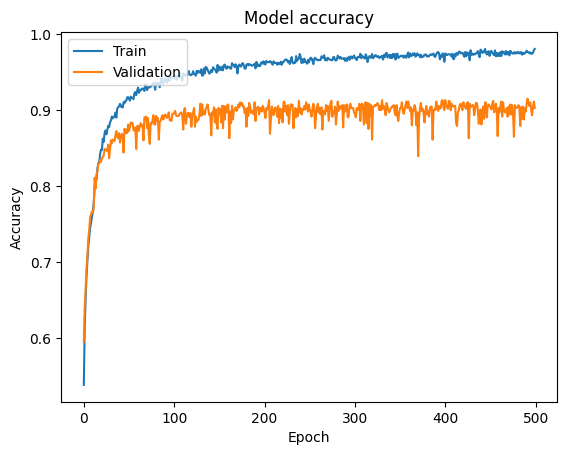

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['avg_accuracy'])
plt.plot(history.history['val_avg_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)


In [13]:
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised LSTM
              precision    recall  f1-score   support

           0       0.87      0.93      0.89       661
           1       0.92      0.86      0.89       662

    accuracy                           0.89      1323
   macro avg       0.89      0.89      0.89      1323
weighted avg       0.89      0.89      0.89      1323

0.891156462585034


In [14]:
for i, layer in enumerate(model.layers):
    print(layer.name, i)

input_2 0
embedding_1 1
lstm_1 2
time_distributed 3
global_average_pooling1d 4
flatten 5
multiply 6
before_split 7
tf_op_layer_split 8
concatenate 9
reshape 10
conv2d 11
batch_normalization 12
flatten_1 13
op_main 14
op_conv 15
avg 16


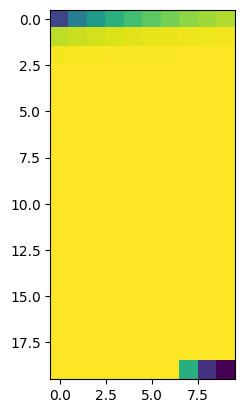

In [15]:
prr = 71
f = Model(model.input, model.layers[7].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr].reshape((20, 10)), cmap='viridis', interpolation='nearest')
plt.show()

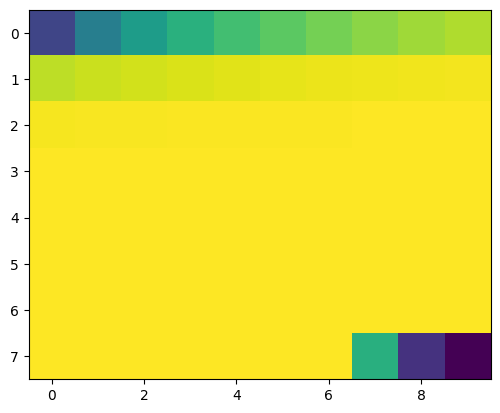

In [16]:
f = Model(model.input, model.layers[10].output)
predictions = f.predict(X_test)
plt.imshow(predictions[prr], cmap='viridis', interpolation='nearest')
plt.show()